In [308]:
import logging
import time

import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_text

# check all lib versions and python version
print(f"Tensorflow version: {tf.__version__}")
print(f"Tensorflow_text version: {tensorflow_text.__version__}")
# protobuf version
import google.protobuf
print(f"protobuf version: {google.protobuf.__version__}")


Tensorflow version: 2.10.1
Tensorflow_text version: 2.10.0
protobuf version: 3.19.6


In [309]:
import pathlib
import random
import string
import re
import numpy as np
import csv

## Preprocessing

In [310]:
file_path = pathlib.Path("../datasets/sastra-dataset.csv")
krama = []
ngoko = []

with file_path.open("r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        krama.append(row["krama"])
        ngoko.append(row["ngoko"])


def text_clean(corpus):
    """
    Cleans a list of text strings by performing the following operations:
    1. Removes any text within square brackets.
    2. Replaces specific accented characters with their non-accented counterparts.
    3. Removes any non-alphabetic characters.
    4. Converts all characters to lowercase.
    5. Strips leading and trailing whitespace from each string.
    
    Args:
        corpus (list of str): A list of text strings to be cleaned.
    
    Returns:
        list of str: A list of cleaned text strings.
    """
    cleaned_corpus = []
    for row in corpus:
        row = re.sub(r"\[.*?\]", "", row)
        qs = []
        for word in row.split():
            word = word.replace("ê", "e").replace("è", "e").replace("ă", "a")
            p1 = re.sub(pattern="[^a-zA-Z]", repl=" ", string=word)
            p1 = p1.lower()
            qs.append(p1)
        cleaned_row = " ".join(qs).strip()
        if cleaned_row:
            cleaned_corpus.append(cleaned_row)
    return cleaned_corpus


cleaned_krama = text_clean(krama)
cleaned_ngoko = text_clean(ngoko)

# Remove duplicates data
unique_krama = set()
filtered_krama = []
filtered_ngoko = []

for k, n in zip(cleaned_krama, cleaned_ngoko):
    if k not in unique_krama:
        unique_krama.add(k)
        filtered_krama.append(k)
        filtered_ngoko.append(n)

# Write cleaned data to CSV
output_path = pathlib.Path("../datasets/cleaned-dataset.csv")
with output_path.open("w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["krama", "ngoko"])
    writer.writeheader()
    for k, n in zip(filtered_krama, filtered_ngoko):
        writer.writerow({"krama": k, "ngoko": n})

In [311]:
def clean_sentence(sentence):
    # Remove extra whitespace
    sentence = re.sub(r"\s+", " ", sentence)
    # Strip leading and trailing whitespace
    sentence = sentence.strip()
    return sentence

In [312]:
text_pairs = []
csv_file = pathlib.Path("../datasets/cleaned-dataset.csv")

# Open and read the CSV file
with open(csv_file, encoding="utf-8") as f:
    reader = csv.reader(f)
    # Skip the header row if present
    next(reader)
    
    for row in reader:
        krama, ngoko = row  # Assuming the first column is Krama and the second is Ngoko
        text_pairs.append((clean_sentence(krama), clean_sentence(ngoko)))

# text_pairs = tf.data.Dataset.from_tensor_slices(text_pairs)

In [313]:
# print 1 - 10 of the text pairs
for i in range(20):
    print(text_pairs[i])

('bab alakirabi wayuh kalihan boten', 'bab ala kirabi awake karo ora')
('karanganipun suwara sandiasma', 'caritane swara sandiasma')
('kaecap ing pangecapanipun tuwan h a benyamin ing nagari semarang', 'omongan pak benyamin nang semarang')
('ing taun', 'tahun')
('adat tatacara ingkang kawastanan prayogi saking pamanggih kula ingkang tumusipun adamel sakeca tuwin mulya dhateng ingkang gadhah adat lan tatacara wau', 'adat kebiasaan sing dianggep penting miturut pikiranku sing tujuan nggawe becik lan mulia marang sing duwe adat kebiasaan mau')
('manut ingkang katingal ing kathah bangsa kulit pethak adat tuwin caranipun sae pathokanipun angugemi dhawuhing allah kados ta manusa kedah nedha kringetipun piyambak sinten ingkang boten purun kumlawe inggih badhe kaluwen sanak sadherek boten badhe purun nguluri sandhang tedha dalah tiyang sepuh inggih lumuh ngrembag kabetahanipun anak ingkang sampun wancinipun aceceker piyambak', 'ngono sing katon akeh bangsa kulit putih adat lan carane apik cont

In [314]:
# check the shortest and longest sentence
def get_sentence_lengths(sentence_list):
    sentence_lengths = [len(sentence.split()) for sentence in sentence_list]
    return sentence_lengths

krama_sentences = [pair[0] for pair in text_pairs]
ngoko_sentences = [pair[1] for pair in text_pairs]

krama_lengths = get_sentence_lengths(krama_sentences)
ngoko_lengths = get_sentence_lengths(ngoko_sentences)

print(f"Krama sentence lengths: {krama_lengths[:5]}")
print(f"Ngoko sentence lengths: {ngoko_lengths[:5]}")


# longes by word count
max_krama_length = max(krama_lengths)
max_ngoko_length = max(ngoko_lengths)

print(f"Max Krama length: {max_krama_length}")
print(f"Max Ngoko length: {max_ngoko_length}")

# shortest by word count
min_krama_length = min(krama_lengths)
min_ngoko_length = min(ngoko_lengths)

print(f"Min Krama length: {min_krama_length}")
print(f"Min Ngoko length: {min_ngoko_length}")

Krama sentence lengths: [5, 3, 10, 2, 21]
Ngoko sentence lengths: [6, 3, 5, 1, 19]
Max Krama length: 103
Max Ngoko length: 82
Min Krama length: 1
Min Ngoko length: 1


In [315]:
import random
import tensorflow as tf

# Assuming text_pairs is your list of (krama_sentence, ngoko_sentence)
random.shuffle(text_pairs)

# Calculate the number of samples for each set
total_samples = len(text_pairs)
num_val_samples = int(0.1 * total_samples)
num_test_samples = int(0.1 * total_samples)
num_train_samples = total_samples - num_val_samples - num_test_samples

# Split the dataset
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

# Prepare datasets for TensorFlow
train_kr = [pair[0] for pair in train_pairs]
train_ng = [pair[1] for pair in train_pairs]

val_kr = [pair[0] for pair in val_pairs]
val_ng = [pair[1] for pair in val_pairs]

test_kr = [pair[0] for pair in test_pairs]
test_ng = [pair[1] for pair in test_pairs]

train_kr = tf.data.Dataset.from_tensor_slices(train_kr)
train_ng = tf.data.Dataset.from_tensor_slices(train_ng)

val_kr = tf.data.Dataset.from_tensor_slices(val_kr)
val_ng = tf.data.Dataset.from_tensor_slices(val_ng)

test_kr = tf.data.Dataset.from_tensor_slices(test_kr)
test_ng = tf.data.Dataset.from_tensor_slices(test_ng)

print(f"Total samples: {total_samples}")
print(f"Training samples: {num_train_samples}")
print(f"Validation samples: {num_val_samples}")
print(f"Test samples: {num_test_samples}")

Total samples: 6056
Training samples: 4846
Validation samples: 605
Test samples: 605


In [316]:
for en, id in zip(train_kr.take(5), train_ng.take(5)):
    print(en.numpy().decode("utf-8"))
    print(id.numpy().decode("utf-8"))
    print()

lajeng nyelir utawi rabi malih
lajeng nyelir utawi rabi malih

ulat sumeh jalaran remeh kemawon murugaken grejegan
ulat sumeh jalaran remeh mung nggawa rubuh

saben dinten tansah abratayuda rebat
saben dina tansah perang perangane

sapunika nama kali panjang
jenenge kali panjang

awrat entheng kagotong tiyang kalih
berat enteng digotong wong loro


lajeng nyelir utawi rabi malih

ulat sumeh jalaran remeh kemawon murugaken grejegan
ulat sumeh jalaran remeh mung nggawa rubuh

saben dinten tansah abratayuda rebat
saben dina tansah perang perangane

sapunika nama kali panjang
jenenge kali panjang

awrat entheng kagotong tiyang kalih
berat enteng digotong wong loro



In [317]:
model_name = "../tokenizer/ted_hrlr_tokenizer"
tokenizers = tf.saved_model.load(model_name)

In [318]:
[item for item in dir(tokenizers.ng) if not item.startswith("_")]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [319]:
# vocab size
(tokenizers.kr.get_vocab_size()), (tokenizers.ng.get_vocab_size())

(<tf.Tensor: shape=(), dtype=int32, numpy=1279>,
 <tf.Tensor: shape=(), dtype=int32, numpy=979>)

In [320]:
# test tokenizer
encoded = tokenizers.kr.tokenize(["kawulaningsun wong pagunungan kabeh"])
decoded = tokenizers.kr.detokenize(encoded)
print(encoded.numpy()[0])
print(decoded.numpy()[0].decode("utf-8"))

# sub word check
tokens = tokenizers.kr.lookup(encoded)
print(tokens)

# eng
encoded = tokenizers.ng.tokenize(["aku wong gunung kabeh"])
decoded = tokenizers.ng.detokenize(encoded)
print(encoded.numpy()[0])
print(decoded.numpy()[0].decode("utf-8"))

# sub word check
tokens = tokenizers.ng.lookup(encoded)
print(tokens)

[   2  211   77  514  633   19   42   63 1144  604    3]
kawulaningsun wong pagunungan kabeh
<tf.RaggedTensor [[b'[START]', b'kawula', b'##ning', b'##sun', b'wong', b'p', b'##a',
  b'##g', b'##unungan', b'kabeh', b'[END]']]>
[  2  35  30 103  44   3]
aku wong gunung kabeh
<tf.RaggedTensor [[b'[START]', b'aku', b'wong', b'gunung', b'kabeh', b'[END]']]>


In [321]:
MAX_TOKENS = 64  # 128
BUFFER_SIZE = 20000 #20000
BATCH_SIZE = 32 #64

def prepare_batch(kr, ng):
    kr = tokenizers.kr.tokenize(kr)  # Output is ragged.
    kr = kr[:, :MAX_TOKENS]  # Trim to MAX_TOKngS.
    kr = kr.to_tensor()  # Convert to 0-padded dngse Tngsor

    ng = tokenizers.ng.tokenize(ng)
    ng = ng[:, : (MAX_TOKENS + 1)]
    ng_inputs = ng[:, :-1].to_tensor()  # Drop the [ngD] tokngs
    ng_labels = ng[:, 1:].to_tensor()  # Drop the [START] tokngs

    return (kr, ng_inputs), ng_labels

In [322]:
def make_batches(ds):
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [323]:
train_batches = make_batches(tf.data.Dataset.zip((train_kr, train_ng)))
val_batches = make_batches(tf.data.Dataset.zip((val_kr, val_ng)))

In [324]:
for (kr, ng), ng_labels in train_batches.take(1):
    print(f"kr shape: {kr.shape}")
    print(f"ng shape: {ng.shape}")
    print(f"ng_labels shape: {ng_labels.shape}")

kr shape: (32, 64)
ng shape: (32, 64)
ng_labels shape: (32, 64)


In [325]:
print(ng[0][:10])
print(ng_labels[0][:10])

tf.Tensor([  2 236   0   0   0   0   0   0   0   0], shape=(10,), dtype=int64)
tf.Tensor([236   3   0   0   0   0   0   0   0   0], shape=(10,), dtype=int64)


## Training

(2048, 512)


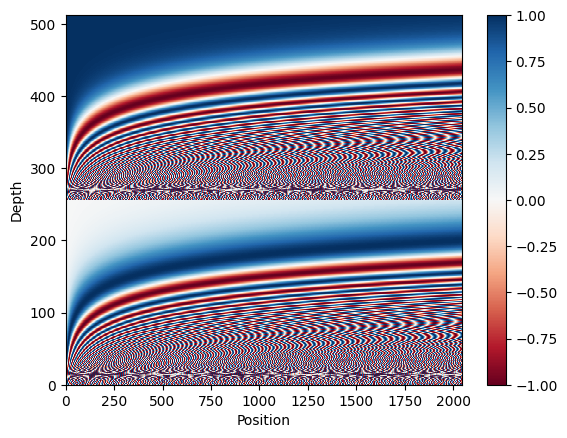

In [326]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap="RdBu")
plt.ylabel("Depth")
plt.xlabel("Position")
plt.colorbar()
plt.show()

In [327]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        print(f"x shape: {x.shape}")
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

embed_kr = PositionalEmbedding(
        vocab_size=tokenizers.kr.get_vocab_size(), d_model=512
    )
embed_ng = PositionalEmbedding(vocab_size=tokenizers.ng.get_vocab_size(), d_model=512)

kr_emb = embed_kr(kr)
ng_emb = embed_ng(ng)

ng_emb._keras_mask

In [328]:
embed_kr = PositionalEmbedding(vocab_size=tokenizers.kr.get_vocab_size(), d_model=512)
embed_ng = PositionalEmbedding(vocab_size=tokenizers.ng.get_vocab_size(), d_model=512)

kr_emb = embed_kr(kr)
ng_emb = embed_ng(ng)

ng_emb._keras_mask

x shape: (32, 64, 512)
x shape: (32, 64, 512)


<tf.Tensor: shape=(32, 64), dtype=bool, numpy=
array([[ True,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [329]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [330]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x, key=context, value=context, return_attention_scores=True
        )

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [331]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(kr_emb.shape)
print(ng_emb.shape)
print(sample_ca(ng_emb, kr_emb).shape)

(32, 64, 512)
(32, 64, 512)
(32, 64, 512)


In [332]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [333]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(kr_emb.shape)
print(sample_gsa(kr_emb).shape)

(32, 64, 512)
(32, 64, 512)


In [334]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [335]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [336]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [337]:
class Encoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [338]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.cross_attention = CrossAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [339]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [340]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        *,
        num_layers,
        d_model,
        num_heads,
        dff,
        input_vocab_size,
        target_vocab_size,
        dropout_rate=0.1
    ):
        super().__init__()
        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=target_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [341]:
num_layers = 2 #4
d_model = 64  # 128
dff = 128 #512
num_heads = 2 #8
dropout_rate = 0.1 #0.1

In [342]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.kr.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.ng.get_vocab_size().numpy(),
    dropout_rate=dropout_rate,
)

In [343]:
output = transformer((kr, ng))

print(kr.shape)
print(ng.shape)
print(output.shape)

x shape: (32, 64, 64)
x shape: (32, 64, 64)
(32, 64)
(32, 64)
(32, 64, 979)


In [344]:
transformer.summary()

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  181952    
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  181952    
                                                                 
 decoder_5 (Decoder)         multiple                  229440    
                                                                 
 dense_85 (Dense)            multiple                  63635     
                                                                 
Total params: 475,027
Trainable params: 475,027
Non-trainable params: 0
_________________________________________________________________


In [345]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps,
        }

Text(0.5, 0, 'Train Step')

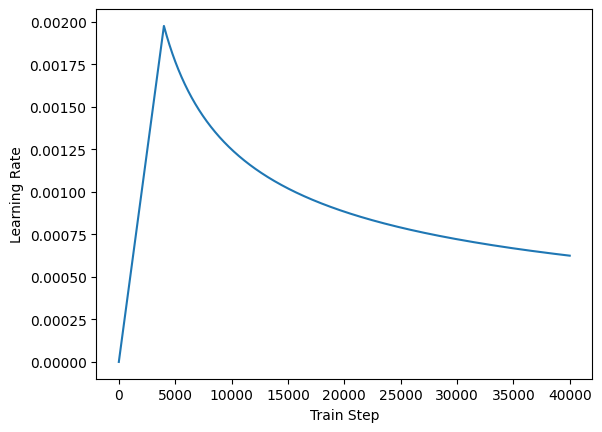

In [346]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [347]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [348]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
his = transformer.fit(train_batches, epochs=100, validation_data=val_batches) 

Epoch 1/100
x shape: (None, None, 64)
x shape: (None, None, 64)
x shape: (None, None, 64)
x shape: (None, None, 64)
152/152 [==============================] - ETA: 0s - loss: 6.7845 - masked_accuracy: 0.0457x shape: (None, None, 64)
x shape: (None, None, 64)
152/152 [==============================] - 108s 640ms/step - loss: 6.7845 - masked_accuracy: 0.0457 - val_loss: 6.5273 - val_masked_accuracy: 0.0892
Epoch 2/100
152/152 [==============================] - 92s 608ms/step - loss: 6.2811 - masked_accuracy: 0.0941 - val_loss: 6.0279 - val_masked_accuracy: 0.0918
Epoch 3/100
152/152 [==============================] - 92s 605ms/step - loss: 5.8836 - masked_accuracy: 0.0940 - val_loss: 5.7929 - val_masked_accuracy: 0.0939
Epoch 4/100
152/152 [==============================] - 101s 667ms/step - loss: 5.7161 - masked_accuracy: 0.1001 - val_loss: 5.6302 - val_masked_accuracy: 0.1028
Epoch 5/100
152/152 [==============================] - 91s 597ms/step - loss: 5.4783 - masked_accuracy: 0.1136 

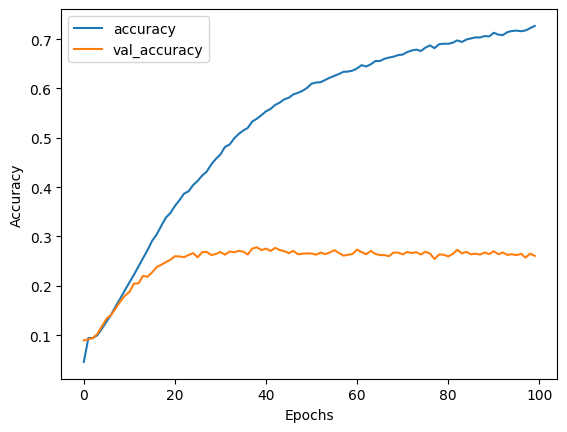

In [349]:
import matplotlib.pyplot as plt

plt.plot(his.history["masked_accuracy"])
plt.plot(his.history["val_masked_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend(["accuracy", "val_accuracy"])
plt.show()

## Evaluation

In [350]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Ngoko, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.kr.tokenize(sentence).to_tensor()

        encoder_input = sentence

        start_end = self.tokenizers.ng.tokenize([""])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = self.tokenizers.ng.detokenize(output)[0]  # Shape: `()`.

        tokens = self.tokenizers.ng.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:, :-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [351]:
translator = Translator(tokenizers, transformer)

In [352]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [353]:
sentence = "kula badhe dhahar"
ground_truth = "aku arep mangan"

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence)
)
print_translation(sentence, translated_text, ground_truth)

x shape: (1, 5, 64)
x shape: (1, 1, 64)
x shape: (1, 5, 64)
x shape: (1, 2, 64)
x shape: (1, 5, 64)
x shape: (1, 3, 64)
x shape: (1, 5, 64)
x shape: (1, 4, 64)
x shape: (1, 5, 64)
x shape: (1, 4, 64)
Input:         : kula badhe dhahar
Prediction     : aku arep mangan
Ground truth   : aku arep mangan


In [354]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode("utf-8") for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode("utf-8") for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [355]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.ng.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.ng.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h + 1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f"Head {h+1}")

    plt.tight_layout()
    plt.show()

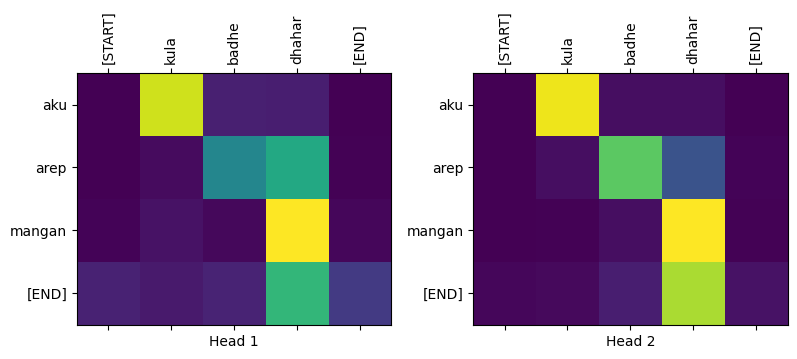

In [356]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [357]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result, tokens, attention_weights) = self.translator(
            sentence, max_length=MAX_TOKENS
        )

        return result

In [358]:
translator = ExportTranslator(translator)

In [359]:
translator(tf.constant("kula badhe dhahar")).numpy()

x shape: (None, None, 64)
x shape: (1, None, 64)
x shape: (None, None, 64)
x shape: (1, None, 64)


b'aku arep mangan'

In [360]:
tf.saved_model.save(translator, export_dir="../models/translator_id-en")

x shape: (None, None, 64)
x shape: (1, None, 64)
x shape: (None, None, 64)
x shape: (1, None, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)
x shape: (None, 64, 64)


INFO:tensorflow:Assets written to: ../models/translator_id-en\assets


INFO:tensorflow:Assets written to: ../models/translator_id-en\assets


In [365]:
reloaded = tf.saved_model.load("../models/translator_id-en")

In [366]:
reloaded(tf.constant("kula badhe dhahar")).numpy()

b'aku arep mangan'

In [363]:
def translate(kr_text):
    output = reloaded(tf.constant(kr_text)).numpy()
    output = output.decode("utf-8")
    output = re.sub(r"\s*([^\s\w\d])\s*", r"\1", output)
    return output

In [367]:
word_to_translate = [
    "sarta atur pratandha asoring kasekten",
    "kaot nama kemawon",
    "kajeng tuwan lajeng mariksa ingkang kawastanan talaga balekabang ugi",
    "enjingipun jam nem tuwan tetiga pangkat dhateng pakalongan",
    "ingkang karsa maos",
    "margi dumugi jatining kamulyan",
    "dados piwulang ingkang kadamel werit wau panyimpenipun inggih katitipaken ing piwulang ingkang gumelar nanging pilih janma ingkang uninga",
    "majeng majenging kawruh sontan santuning watak bebuden ing salebetipun taksih dados tiyang ngawam",
    "kawontenan tuwin warni warninipun tiyang kas",
    "manah dhateng warni warnining bilai",
    "raden rangga enggal katimbalan",
]

ground_truth = [
    "lan tandha kekuatane",
    "ora papa",
    "kowe banjur mriksa talaga balekabang",
    "isuk jam nem kowe numpak apa menyang pekalongan",
    "sing arep maca",
    "tekaning kamulyan",
    "dadi ilmu sing wis digawe akeh kuwi disimpen nang guru sing wis berpengalaman  tapi pilih wong sing pinter",
    "munggah ilmu lan watak apik isih dadi wong awam",
    "keadaan lan rupane wong sugih",
    "ati ana rupa rupa bebaya",
    "mas rangga cepet diundang",
]

for i, word in enumerate(word_to_translate):
    translated = translate(word)
    print(f"Input: {word}")
    print(f"Translation: {translated}")
    print(f"Ground truth: {ground_truth[i]}")
    print()

Input: sarta atur pratandha asoring kasekten
Translation: lan tandha telu kekareng reki
Ground truth: lan tandha kekuatane

Input: kaot nama kemawon
Translation: kecunget
Ground truth: ora papa

Input: kajeng tuwan lajeng mariksa ingkang kawastanan talaga balekabang ugi
Translation: kowe banjur mriksa talaga balekabang
Ground truth: kowe banjur mriksa talaga balekabang

Input: enjingipun jam nem tuwan tetiga pangkat dhateng pakalongan
Translation: esuk pakebon wong tekalongan
Ground truth: isuk jam nem kowe numpak apa menyang pekalongan

Input: ingkang karsa maos
Translation: sing maca
Ground truth: sing arep maca

Input: margi dumugi jatining kamulyan
Translation: tekaning kamulyan
Ground truth: tekaning kamulyan

Input: dados piwulang ingkang kadamel werit wau panyimpenipun inggih katitipaken ing piwulang ingkang gumelar nanging pilih janma ingkang uninga
Translation: dadi piwulang sing wis dilakoni kuwi wis rampung karepe paraane para akeh sing wis ditetetemelan sing ditekani
Ground

In [368]:
# Install and import required libraries
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

nltk.download("punkt")

# Assuming 'reloaded' is your trained model
# and 'test_pairs' is your list of (krama_sentence, ngoko_sentence)


# Function to tokenize a sentence consistently
def tokenize_sentence(sentence):
    return nltk.word_tokenize(sentence.lower())


# Prepare reference and candidate translations
references = []
candidates = []

for krama_sentence, ngoko_sentence in test_pairs:
    # Tokenize reference sentence (list of tokenized references)
    reference = [tokenize_sentence(ngoko_sentence)]
    # Get model translation and tokenize it
    translated_text = translate(krama_sentence)  # Ensure 'translate' outputs a sentence
    candidate = tokenize_sentence(translated_text)

    references.append(reference)
    candidates.append(candidate)

    print(f"Krama: {krama_sentence}")
    print(f"Ngoko: {ngoko_sentence}")
    print(f"Model: {translated_text}")
    print()

# Calculate BLEU scores with n-grams from 1 to 4
smoothing_function = SmoothingFunction().method1
for n in range(1, 5):
    # Define weights for n-grams
    weights = tuple((1.0 / n for _ in range(n))) + (0.0,) * (4 - n)
    score = corpus_bleu(
        references, candidates, weights=weights, smoothing_function=smoothing_function
    )
    print(f"BLEU score for {n}-gram: {score:.4f}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Krama: mubeng inggilipun kalih meter punika
Ngoko: muter loro meter
Model: kowe dhuwure terus api

Krama: sih
Ngoko: isik
Model: iku

Krama: dhateng ing gantara ngantos inggil
Ngoko: tekan langit
Model: dhateng sentara omahg sirah

Krama: dadi bener banget karsane sang
Ngoko: bener tenan karepe wong iku
Model: bendhek kepungkur

Krama: kori geladhag awit saben sonten
Ngoko: lawange gedhe banget saben sore
Model: kori tedhap amarga sengin

Krama: cublesan dariji gotekipun ingkang bublesi
Ngoko: ruwet banget rambutmu sing gimbal
Model: co wisha piye tangun kobungan

Krama: patih mangke sakedhap gandarwo ingkang
Ngoko: patih bentar wae gandheng karo
Model: patih gedhe banget sapentar

Krama: namung satunggal saben dinten lir
Ngoko: mung siji saben dina kaya
Model: mung siji saben dina

Krama: mangka asring asring katrocohan amargi
Ngoko: ya akeh banget sing salah paham amarga
Model: jahya kabalangan merga asring

Krama: titagi
Ngoko: titip
Model: turu

Krama: kados kinebur pancurating toy

<!-- use METEOR -->

